In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
from numpy import random
import pymc3 as pm
import theano.tensor as T
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 7)
plt.style.use('ggplot')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
num_obs = 1000
num_features = 10
alpha = random.normal(size = 1)
betas=  random.normal(size = num_features)
print(alpha)
# fake data
data =  random.normal(size = (num_obs,num_features))
#np.savetxt("foo.csv", data, delimiter=",")

[1.35516745]


In [4]:
### y = alpha + b*data + noise

y_real = alpha + np.sum(betas*data,axis=1) + random.normal(size=1000)
y_real.shape

(1000,)

In [5]:
col_name = ['f'+str(x) for x in range(10)]
data_df = pd.DataFrame(data,columns=col_name)
data_df['y'] = y_real
data_df.to_csv("linear_reg_data.csv",index=False)

In [6]:
with pm.Model() as model:
    
    
    alpha = pm.Normal('alpha', tau=.01,shape=(1))
    betas = pm.Normal('betas', tau=.01, shape = (1,num_features))
    
    s = pm.HalfNormal('s',tau=1)
    mu = alpha + T.dot(betas,data.T)
    temp = pm.Normal('temp',mu=mu , tau= s**-2, observed = y_real)
    
    step = pm.NUTS()
    trace = pm.sample(2500,step=step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [s, betas, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:53<00:00, 222.38draws/s]


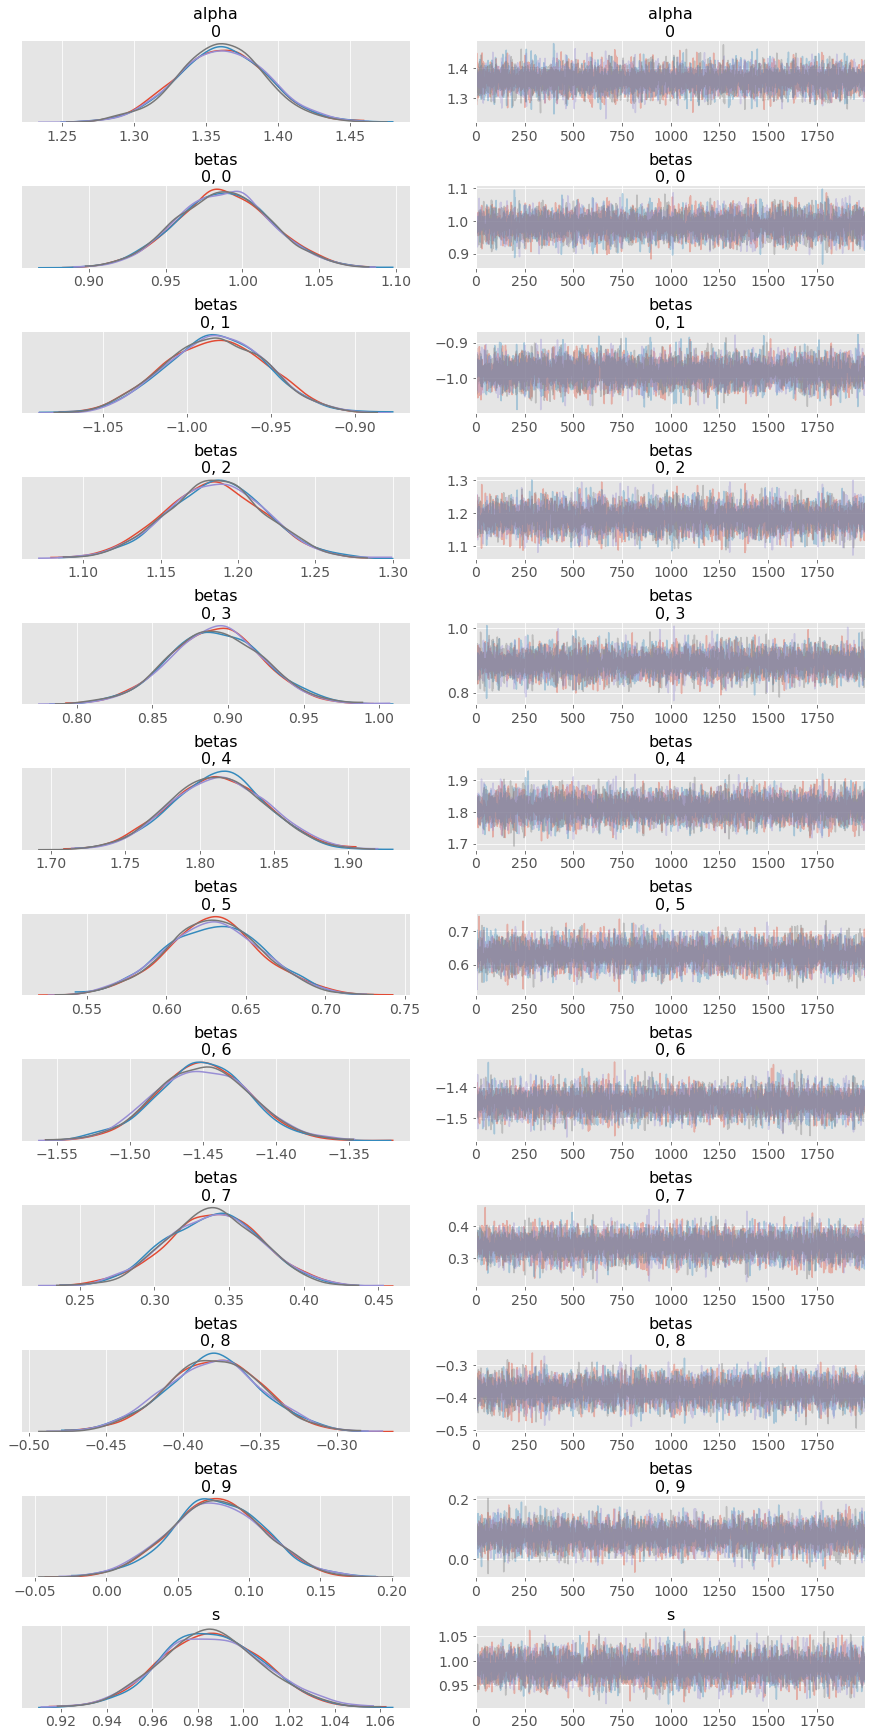

In [7]:
pm.traceplot(trace[500:]);

In [11]:
pm.summary(trace[500:])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha__0,1.360735,0.031100,0.000273,1.298459,1.421487,13706.739998,0.999970
betas__0_0,0.987198,0.030538,0.000267,0.928044,1.047941,13758.674559,0.999797
betas__0_1,-0.983180,0.030087,0.000257,-1.040120,-0.924176,12892.725212,0.999945
betas__0_2,1.185110,0.032226,0.000322,1.121990,1.248787,13039.247982,1.000309
betas__0_3,0.891544,0.030872,0.000295,0.834461,0.956006,12568.131737,0.999882
betas__0_4,1.812198,0.032222,0.000280,1.749316,1.873614,14510.868391,1.000256
betas__0_5,0.629464,0.030562,0.000259,0.568011,0.687882,12970.238241,0.999837
betas__0_6,-1.450368,0.031929,0.000256,-1.514696,-1.388469,13441.686190,0.999786
betas__0_7,0.339129,0.031700,0.000269,0.275491,0.399363,13965.567348,0.999883
betas__0_8,-0.380624,0.030659,0.000283,-0.443627,-0.323337,13396.097133,0.999827


In [12]:
size=100
x = np.linspace(0,1,size)
true_slope = 5
true_intercept = 1
true_reg_line = true_slope*x + true_intercept
y  =  true_reg_line+ random.normal(scale=0.5,size=size)

# add oulier
x_out = np.append(x,[.1,.15,.2])
y_out = np.append(y,[8,6,9])

data = dict(x=x_out,y=y_out)
#print(data)

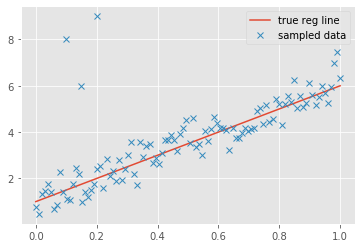

In [13]:
plt.plot(x,true_reg_line,label="true reg line")
plt.plot(x_out,y_out,'x',label="sampled data")
plt.legend()

In [14]:
with pm.Model() as model:
    pm.glm.GLM.from_formula('y~x',data)
    trace = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, x, Intercept]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:04<00:00, 2960.28draws/s]
The acceptance probability does not match the target. It is 0.8840360696376086, but should be close to 0.8. Try to increase the number of tuning steps.


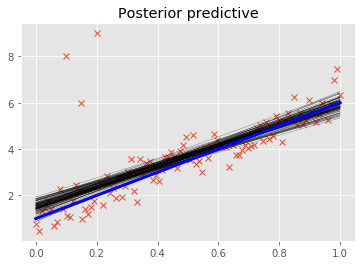

In [15]:
plt.plot(x_out,y_out,'x')
pm.plot_posterior_predictive_glm(trace, samples=100,
                                 label='posterior predictive regression lines')
plt.plot(x, true_reg_line,
         label='true regression line', lw=3., c='b')

In [16]:
normal_dist = pm.Normal.dist(mu=0,sd=1)
student_t = pm.StudentT.dist(mu=0,lam=1,nu=1)
x_eval = np.linspace(-8,8,300)

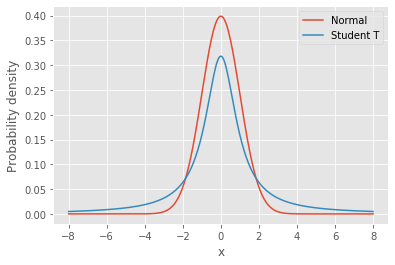

In [17]:

plt.plot(x_eval,T.exp(normal_dist.logp(x_eval)).eval(),label = "Normal")
plt.plot(x_eval,T.exp(student_t.logp(x_eval)).eval(),label="Student T")
plt.xlabel('x')
plt.ylabel('Probability density')
plt.legend()

In [18]:

with pm.Model() as model:
    studentT = pm.glm.families.StudentT()
    pm.glm.GLM.from_formula('y~x',data=data,family=studentT)
    trace1 = pm.sample(3000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lam, x, Intercept]
Sampling 4 chains: 100%|██████████| 14000/14000 [00:06<00:00, 2084.24draws/s]
The acceptance probability does not match the target. It is 0.8895664471777195, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6455fd0fd0>,
      dtype=object)

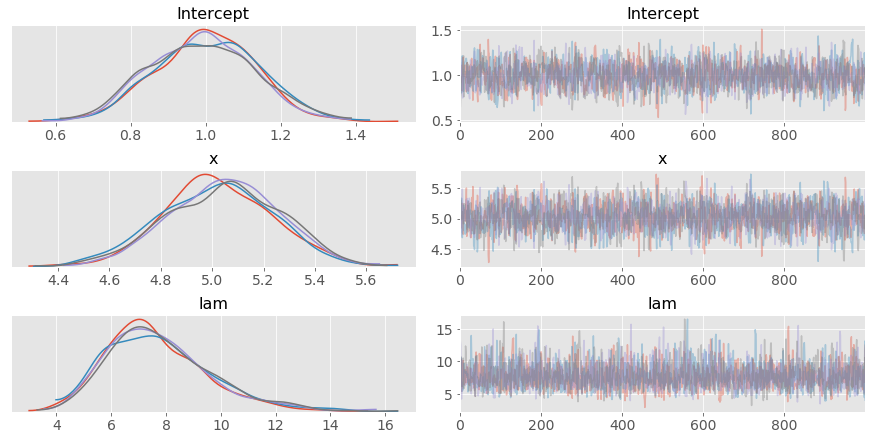

In [19]:
pm.traceplot(trace1[:1000])


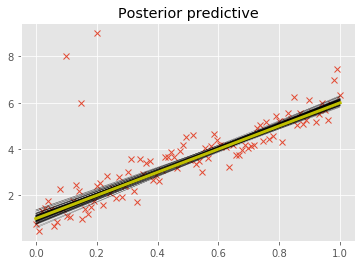

In [20]:
plt.plot(x_out,y_out,'x')
pm.plot_posterior_predictive_glm(trace1, samples=100,
                                 label='posterior predictive regression lines')
plt.plot(x, true_reg_line,
         label='true regression line', lw=3., c='y')